In [2]:
from frozen_lake import *
env = FrozenLakeEnvSequentialMultigoal(goal=2)
print(env.__doc__)


    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following

        SFFF
        FHFH
        FFFH
        HFFG

    S   : starting point, safe
    F   : frozen surface, safe
    H   : hole, fall to your doom
    1|2 : goal for agent 1 or agent 2

    The episode ends when you reach the all the goals for a corresponding agent.
    You receive a reward of 1 each time you reach a goal, and zero otherwise.

    


In [3]:
# Some basic imports and setup
import numpy as np, numpy.random as nr, gym
import scipy.sparse
import matplotlib.pyplot as plt
import math
import pickle
from collections import defaultdict
%matplotlib inline

# Seed RNGs so you get the same printouts as me
env.seed(0); from gym.spaces import prng; prng.seed(10)

NUM_ITER = 75
GAMMA = 0.95

In [4]:
def categorical_sample(prob_n):
    """
    Sample from categorical distribution
    Each row specifies class probabilities
    """
    prob_n = np.asarray(prob_n)
    csprob_n = np.cumsum(prob_n)
    return (csprob_n > np.random.rand()).argmax()

class MDP(object):
    def __init__(self, env):
        P, nS, nA, desc = MDP.env2mdp(env)
        self.P = P # state transition and reward probabilities, explained below
        self.nS = nS # number of states
        self.nA = nA # number of actions
        self.desc = desc # 2D array specifying what each grid cell means (used for plotting)
        self.env = env
        self.T = None

    def env2mdp(env):
        return {s : {a : [tup[:3] for tup in tups] for (a, tups) in a2d.items()} for (s, a2d) in env.P.items()}, env.nS, env.nA, env.desc
    
    def get_transition_matrix(self):
        """Return a matrix with index S,A,S' -> P(S'|S,A)"""
        if self.T is None:
            print('generating')
#             T = defaultdict(lambda : 0)
            T = np.zeros([self.nS, self.nA, self.nS])
            for s in range(self.nS):
                for a in range(self.nA):
                    transitions = self.P[s][a]
                    s_a_s = {t[1]:t[0] for t in transitions}
                    for s_prime in range(self.nS):
                        if s_prime in s_a_s:
                            T[s, a, s_prime] = s_a_s[s_prime]
            self.T = T
        return self.T
    
    def sample_transition(self, state, action):
        sas = self.P[state][action]
        sample = categorical_sample([s_prime[0] for s_prime in sas])
        return sas[sample][1]
        
    
mdp = MDP(env)

In [5]:
def compute_traj_likelihood(mdp, traj, actions):
    """
    Naive likelihood calculation. Should work ok for simple gridworld with short trajectories
    """
    transitions = [(traj[i], actions[i], traj[i+1]) for i in range(len(traj)-1)]
    likelihood = 1.0
    for s,a,s_prime in transitions:
        t = mdp.P[s][a]
        transition_prob = 0.0
        for p, nextstate, _ in t:
            if nextstate == s_prime:
                transition_prob = p
        likelihood *= transition_prob
    return likelihood

def normalize(*args):
    assert min(args) >= 0
    normalized = []
    total = sum(args)
    if total == 0:
        return args
    for arg in args:
        normalized.append(arg / total)
    return tuple(normalized)

In [6]:
class Belief:
    def __init__(self, state_index, total_states, p):
        self.state_index = state_index
        self.total_states = total_states
        self.p = p
    
    def update_p(self, new_p):
        self.p = new_p
    
    @property
    def vector(self):
        v = np.zeros(self.total_states * 2)
        v[self.state_index * 2] = self.p
        v[self.state_index *2 + 1] = 1.0 - self.p
        v = v.reshape([-1, 1])
        return v
    
    def __eq__(self, b2):
        return b2.p == self.p and b2.state_index == self.state_index
    
    def __sub__(self, b2):
        """return L1 distance between belief vectors"""
        if self.state_index == b2.state_index:
            return abs(self.p - b2.p) + abs((1-self.p) - (1-b2.p))
        else:
            return 2.0
        
def generate_belief_points(initial_belief, mdp1, mdp2, num_points=1e3, max_iters=200):
    points = np.array([initial_belief])
    mdps = [mdp1, mdp2]
    iters = 0
    while len(points) < num_points and iters < max_iters:
        frontier = np.array([])
        for b in points:
            mdp = mdps[categorical_sample([b.p, 1.0 - b.p])]
            action_points = [0]*mdp.nA
            for a in np.random.permutation(range(mdp.nA)):
               
                new_state = mdp.sample_transition(b.state_index, a)
                lik1 = compute_traj_likelihood(mdp1, [b.state_index, new_state], [a])
                lik2 = compute_traj_likelihood(mdp2, [b.state_index, new_state], [a])
                new_p = normalize(b.p*lik1, (1.0 - b.p)*lik2)[0]
                action_points[a] = Belief(new_state, b.total_states, new_p)
            
            action_points = np.array(action_points)
            distances = points.reshape([-1, 1]) - action_points.reshape([1, -1])
            min_distances = np.min(distances, axis=0)
            
            new_point = action_points[np.argmax(min_distances)]
            
            if new_point not in points:
                points = np.append(points, new_point)
                
        iters += 1
#         points = np.append(points, frontier)
    return points

In [17]:
def compute_belief_vector(mdp1, mdp2, b, a, obs):
    T1 = mdp1.get_transition_matrix()
    T2 = mdp2.get_transition_matrix()
    
    def p_s_a_sprime(sas_list, sprime):
        t = {sas[1] : sas[0] for sas in sas_list}
        try:
            return t[sprime]
        except:
            return 0.0
    
    new_b = np.zeros(mdp1.nS * 2)
    new_b[obs*2] = T1[b.state_index, a, obs]*b.p
    new_b[obs*2+1] = T2[b.state_index, a, obs]*(1 - b.p)
#     Z = T1[b.state_index, a, obs]*b.p + T2[b.state_index, a, obs]*(1 - b.p)
    Z = np.sum(new_b)
    
    return new_b, Z

# def pbvi(mdp1, mdp2, initial_belief, num_points=100, num_iter=100, gamma=1.0):
#     belief_points = generate_belief_points(initial_belief, mdp1, mdp2, num_points)
#     print("Number of belief points: {}".format(len(belief_points)))
#     support_vectors = set()
#     T1, T2 = mdp1.get_transition_matrix(), mdp2.get_transition_matrix()
#     for _ in range(num_iter):
#         print(_)
        
#         support_vector_matrix = np.zeros([len(support_vectors), mdp1.nS*2])
#         for i, v in enumerate(support_vectors):
#             support_vector_matrix[i] = v[0]
        
#         new_support_vectors = set()
        
#         for b in belief_points:
#             alpha_z_a = np.zeros([mdp1.nS, mdp1.nA, len(b.vector)])
#             for a in range(mdp1.nA):
# #                 print(set(np.where(T1[b.state_index, a, :])[0]).union(set(np.where(T2[b.state_index, a, :])[0])))
#                 for obs in set(np.where(T1[b.state_index, a, :])[0]).union(set(np.where(T2[b.state_index, a, :])[0])):
#                     if len(support_vectors) == 0:
#                         continue
#                     new_belief_vector, Z = compute_belief_vector(mdp1, mdp2, b, a, obs)
# #                     if Z != 0:
#                     values = support_vector_matrix.dot(new_belief_vector/Z)
#                     alpha_z_a[obs, a, :] = support_vector_matrix[np.argmax(values)]
                    
            
#             #CRITCH: Understand this -20.0 better, because it seems hacky.
#             action_support_vectors = np.zeros([len(b.vector), mdp1.nA]) - 20.0
#             for s in [b.state_index*2, b.state_index*2+1]:
#                 if b.vector[s] == 0:
#                     continue
#                 ground_state = math.floor(s/2)
#                 for a in range(mdp1.nA):
#                     if (s % 2) == 0:
#                         mdp = mdp1
#                         reward_sum = sum([s_prime[0]*alpha_z_a[s_prime[1], a, s_prime[1]*2] for s_prime in mdp.P[ground_state][a]])
# #                         if reward_sum == -1:
# #                             import pdb; pdb.set_trace()
#                     else:
#                         mdp = mdp2
#                         reward_sum = sum([s_prime[0]*alpha_z_a[s_prime[1], a, s_prime[1]*2 + 1] for s_prime in mdp.P[ground_state][a]])
                        
#                     action_support_vectors[s,a] = sum([s_prime[0]*s_prime[2] for s_prime in mdp.P[ground_state][a]]) + gamma * reward_sum
            
#             values = np.dot(action_support_vectors.T, b.vector)
#             max_action = np.argmax(values)
#             new_support_vectors.add((tuple(action_support_vectors.T[max_action]), max_action))
            
#         if support_vectors == new_support_vectors:
#             break
#         support_vectors = new_support_vectors.copy()
#         print('len', len(support_vectors))

#     return support_vectors

import time

def pbvi(mdp1, mdp2, initial_belief, num_points=100, num_iter=100, gamma=1.0):
    belief_points = generate_belief_points(initial_belief, mdp1, mdp2, num_points)
    print("Number of belief points: {}".format(len(belief_points)))
    support_vectors = set()
    T1, T2 = mdp1.get_transition_matrix(), mdp2.get_transition_matrix()
    
    state_action_rewards = np.zeros([mdp1.nA, mdp1.nS*2])
    for s in range(state_action_rewards.shape[1]):
        for a in range(state_action_rewards.shape[0]):
            ground_state = math.floor(s/2)
            mdp = mdp1 if s % 2 == 0 else mdp2
            state_action_rewards[a, s] = sum([s_prime[0]*s_prime[2] for s_prime in mdp.P[ground_state][a]])
    
    for _ in range(num_iter):
        print(_)
        start = time.time()
        support_vector_matrix = np.zeros([len(support_vectors), mdp1.nS*2])
        
        for i, v in enumerate(support_vectors):
            support_vector_matrix[i] = v[0]
            
        new_support_vectors = set()
        
        alpha_z_a = np.zeros([len(support_vectors), mdp1.nS, mdp1.nA, 2*mdp1.nS])
        for i, v in enumerate(support_vectors):
            for s in range(mdp1.nS):
                for a in range(mdp1.nA):
                    for obs in set(np.where(T1[s, a, :])[0]).union(set(np.where(T2[s, a, :])[0])):
#                         if obs not in [s_prime[1] for s_prime in mdp1.P[s][a]] and obs not in [s_prime[1] for s_prime in mdp2.P[s][a]]:
#                             continue

                        reward_sum = gamma * sum([s_prime[0]*float(s_prime[1]==obs)*v[0][s_prime[1]*2] for s_prime in mdp1.P[s][a]])
                        alpha_z_a[i, obs, a, s*2] = reward_sum

                        reward_sum = gamma * sum([s_prime[0]*float(s_prime[1]==obs)*v[0][s_prime[1]*2+1] for s_prime in mdp2.P[s][a]])
                        alpha_z_a[i, obs, a, s*2+1] = reward_sum

       
        for b in belief_points:
            
            action_support_vectors = state_action_rewards.copy()
            
            
            for a in range(mdp1.nA):
                if len(support_vectors) == 0:
                    continue
                lookahead_value_vector = np.zeros(len(b.vector))
                
                action_obs_vectors = alpha_z_a[:, :, a, :].squeeze()
                max_action_obs_vector_indices = np.argmax(np.dot(action_obs_vectors, b.vector), axis=0).squeeze()    
                for i, obs in enumerate(range(mdp1.nS)):
                    lookahead_value_vector += action_obs_vectors[max_action_obs_vector_indices[i], obs, :]
                    
                action_support_vectors[a, :] += lookahead_value_vector
                
            values = np.dot(action_support_vectors, b.vector)
            max_action = np.argmax(values)
            new_support_vectors.add((tuple(action_support_vectors[max_action]), max_action))
            
        print(time.time() - start)
        if support_vectors == new_support_vectors:
            break
        support_vectors = new_support_vectors.copy()
        print('len', len(support_vectors))

    return support_vectors

In [20]:
if True:
    mdp1 = MDP(FrozenLakeEnvSequentialMultigoal(goal=1, is_slippery=False))
    mdp2 = MDP(FrozenLakeEnvSequentialMultigoal(goal=2, is_slippery=True))
    initial_belief = Belief(24<<2, mdp1.nS, 0.5)
    support_vectors = pbvi(mdp1, mdp2, initial_belief, 200, num_iter=25)

Number of belief points: 323
generating
generating
0
0.024919986724853516
len 5
1
3.936007261276245
len 14
2
8.207690954208374
len 26
3
13.478129863739014
len 42
4
20.523804903030396
len 68
5
34.20199418067932
len 101
6
52.9197723865509
len 153
7
77.3796968460083
len 166
8
79.09806704521179
len 173
9
80.24366593360901
len 176
10
77.30448698997498
len 179
11
82.39620590209961
len 179
12
83.7709550857544
len 193
13
96.86054301261902
len 185
14
245.47925209999084
len 182
15
89.99365401268005
len 184
16
93.65815305709839
len 185
17
92.11515378952026
len 192
18
101.00564885139465
len 197
19
104.34527492523193
len 197
20
102.00871300697327
len 196
21
103.40311193466187
len 198
22
96.26591920852661
len 204
23
94.83090710639954
len 210
24
102.60101318359375
len 208


In [21]:
if True:
    pickle.dump(support_vectors, open('support_vectors.pkl', 'wb'))

if True:
    support_vectors = pickle.load(open('support_vectors.pkl', 'rb'))

In [22]:
import uuid
import os
import imageio

def plot_values(V, pi, s, img_folder=None, img_index=None, show_img=True):
    V = V[:-1]
    goals = s % 4
    goal_inds = [i for i in range(len(V)) if i % 4 == goals]
    V = V[goal_inds]
    V -= np.min(V)
    V /= max(V) if max(V) > 0 else 1.0
    pi = pi[goal_inds]
    plt.figure(figsize=(6,6))
    plt.imshow(V.reshape(8,8), cmap='gray', interpolation='none', aspect='auto', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(8)-.5)
    ax.set_yticks(np.arange(8)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:8, 0:8]
    a2uv = {0:(-1, 0), 2:(0, -1), 4:(1, 0), 6:(0, 1),
            1:(-1, -1), 3:(1, -1), 5:(1, 1), 7:(-1, 1),
            8:(0, 0)}
    Pi = pi.reshape(8,8)
    for y in range(8):
        for x in range(8):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.1, head_length=0.1)
            if str(env.desc[y,x].item().decode()) in '12':
                plt.text(x, y, str(env.desc[y,x].item().decode()),
                         color='g', size=12,  verticalalignment='center',
                         horizontalalignment='center', fontweight='bold')
    
    if s != (8 * 8 * 4):
        plt.plot((s >> 2)%8, (s >> 2)//8, 'ro')
    plt.grid(color='b', lw=2, ls='-')
    
    if img_folder and img_index is not None:
        plt.savefig(os.path.join('figures', img_folder, 'figure%03d.png' % img_index))
    if show_img:
        plt.show()
    
def img_directory_to_gif(img_folder):
    image_files = sorted([f for f in os.listdir(img_folder) if f[-4:] == '.png'])
    images = []
    for fname in image_files:
        images.append(imageio.imread(os.path.join(img_folder, fname)))
    imageio.mimsave(os.path.join(img_folder, 'traj.gif'), images, duration=0.25)

def support_vectors_to_values(support_vectors, belief, nS, current_s):
    support_vectors = list(support_vectors)
    V = np.zeros(nS)
    pi = np.zeros(nS)
    for s in range(nS):
        b = Belief(s, belief.total_states, belief.p)
        vectors = [v[0] for v in support_vectors]
        values = [np.array(alpha).dot(b.vector) for alpha in vectors]
        V[s] = max(values)
        pi[s] = support_vectors[np.argmax(values)][1]
    return V, pi
    
    
def run_mixing_agent(true_mdp, mdp1, mdp2, support_vectors, w1, vis=plot_values, img_folder=None):
    true_mdp.env.reset()
    s1 = mdp1.env.reset()
    s2 = mdp2.env.reset()
    assert s1 == s2, "mdp state spaces must be the same"
    s, done = s1, False
    
    Vs = []
    pi = np.zeros(mdp1.nS)
    
#     w1, w2 = normalize(p1, p2)
    traj, actions = [s,], []
#     V1, V2 = compute_values(mdp1, mdp2, GAMMA, NUM_ITER)
    belief = Belief(s, true_mdp.nS, w1)
    
    img_folder = img_folder or str(uuid.uuid4())
    img_index = 0
    
    os.makedirs(os.path.join('figures', img_folder))
    print(os.listdir('figures'))
    
    while not done:
        print("acting")
        V, pi = support_vectors_to_values(support_vectors, belief, true_mdp.nS, s)
        if vis:
            img_index += 1
            vis(V, pi, s, img_folder, img_index)
            print(belief.p)
        action = pi[s]
        s, r, done, _ = true_mdp.env.step(action)
        traj.append(s)
        actions.append(action)
        l1, l2 = compute_traj_likelihood(mdp1, traj, actions), compute_traj_likelihood(mdp2, traj, actions)
        p1, p2 = normalize(w1*l1, (1-w1)*l2)
        belief = Belief(s, true_mdp.nS, p1)
    if vis:
        img_index += 1
        vis(V, pi, s, img_folder, img_index)
        img_directory_to_gif(os.path.join('figures', img_folder))
        
    return traj


['.DS_Store', '7c362deb-f278-4029-86ec-4b08b0d49922', 'ba79953e-ba5c-4cbe-905d-8e9522b1815d', 'eeeb436b-6aa0-4417-852f-6f8055bbedb4', 'exp1', 'exp2', 'exp3', 'exp4', 'exp5', 'index.html', 'js']
acting


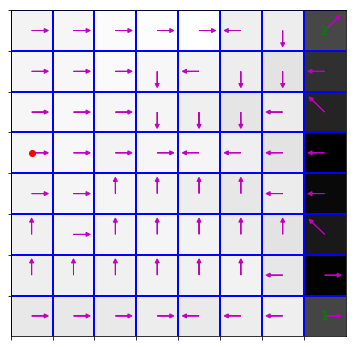

0.5
acting


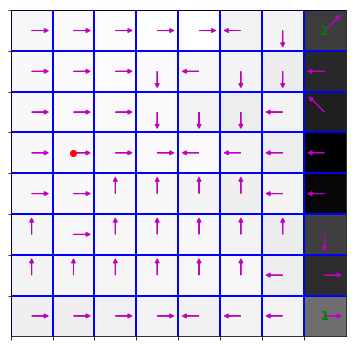

0.5555555555555556
acting


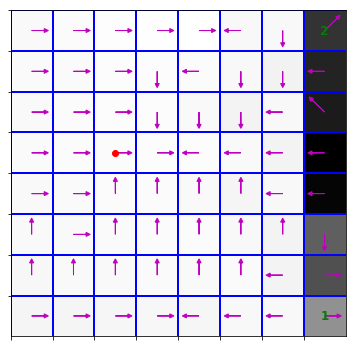

0.6097560975609756
acting


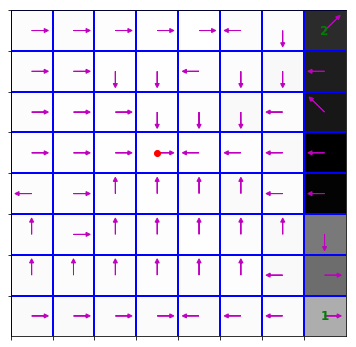

0.6613756613756614
acting


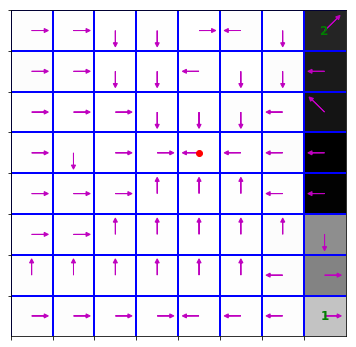

0.7094211123723041
acting


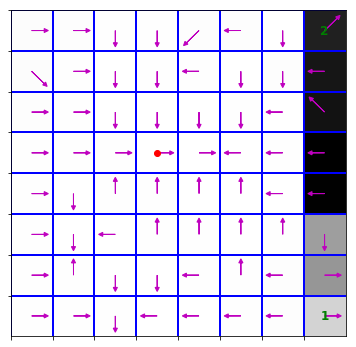

0.7531935406121956
acting


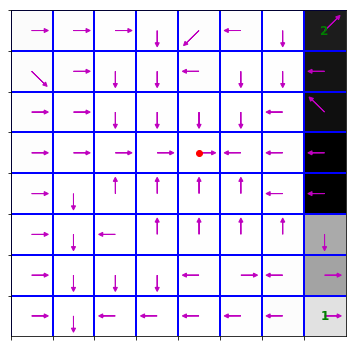

0.7923026215709141
acting


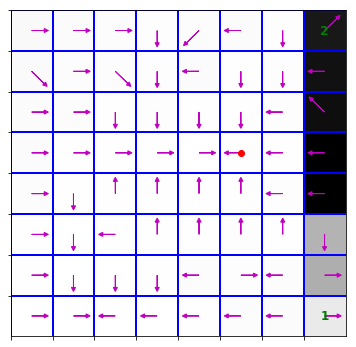

0.8266408490196699
acting


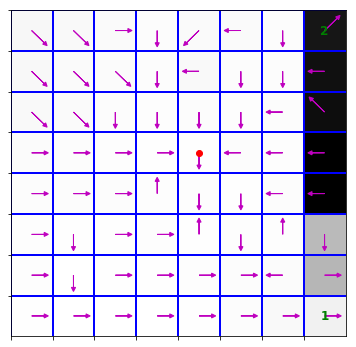

0.8563314268427155
acting


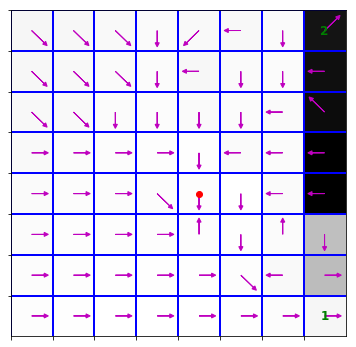

0.8816649354999324
acting


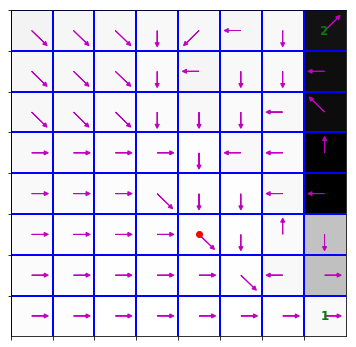

0.9030371268298045
acting


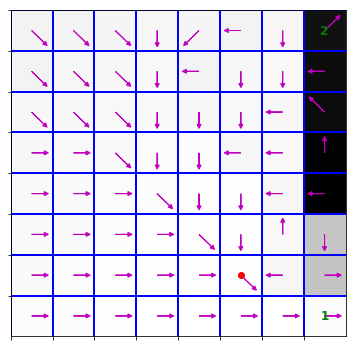

0.9208956647384071
acting


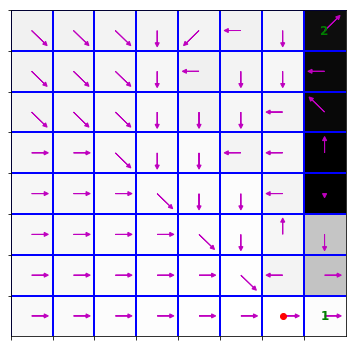

0.9356992379835
acting


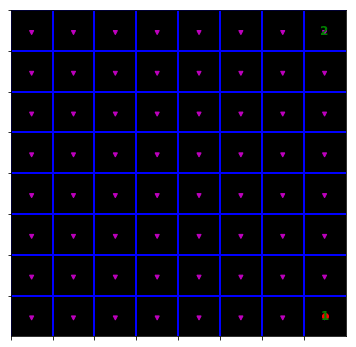

0.9478892380462223


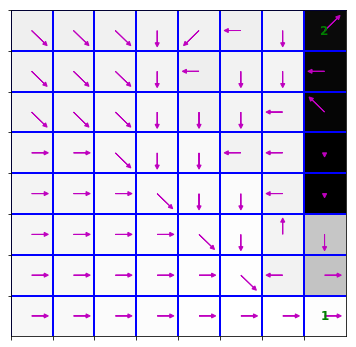

In [23]:
mdp1 = MDP(FrozenLakeEnvSequentialMultigoal(goal=1, is_slippery=False))
mdp2 = MDP(FrozenLakeEnvSequentialMultigoal(goal=2, is_slippery=True))
true_mdp = MDP(FrozenLakeEnvSequentialMultigoal(goal=1, is_slippery=False))

!rm -r figures/exp5
traj = run_mixing_agent(true_mdp, mdp1, mdp2, support_vectors, w1=0.5, img_folder='exp5')

In [24]:
from IPython.display import FileLink

FileLink('figures/exp5/traj.gif')

/Users/nishant/Projects/irl/frozenlake/figures/exp5/traj.gif

Number of belief points: 207
generating
generating
0
0.017060041427612305
len 7
1
2.7168591022491455
len 31
2
9.025461196899414
len 62
3
16.268001079559326
len 88
4
22.668070077896118
len 118
5
30.128928184509277
len 152
6
38.6115300655365
len 190
7
47.8429479598999
len 190
8
48.92943215370178
len 190
9
48.05685830116272
len 190
10
48.02834725379944
len 190
11
47.92939305305481
len 190
12
47.99582600593567
len 190
13
49.99939727783203
len 190
14
47.90156579017639
len 190
15
47.84459114074707
len 190
16
47.90228033065796
len 190
17
47.80482316017151
len 190
18
48.55132579803467
len 190
19
47.7779221534729
len 190
20
48.53550910949707
len 190
21
47.93344283103943
len 190
22
47.98742198944092
len 190
23
48.11956977844238
len 190
24
47.841557025909424
len 190
rm: figures/exp6: No such file or directory
['.DS_Store', '7c362deb-f278-4029-86ec-4b08b0d49922', 'ba79953e-ba5c-4cbe-905d-8e9522b1815d', 'eeeb436b-6aa0-4417-852f-6f8055bbedb4', 'exp1', 'exp2', 'exp3', 'exp4', 'exp5', 'exp6', 'index.h

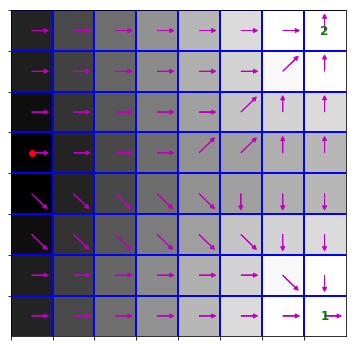

0.5
acting


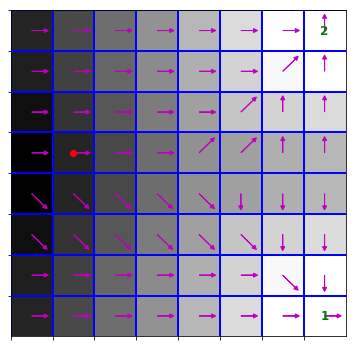

0.5
acting


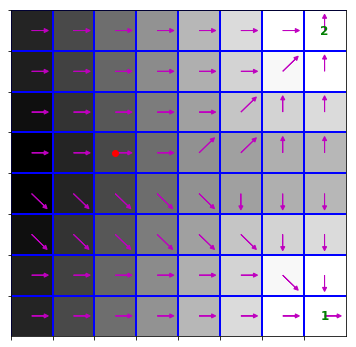

0.5
acting


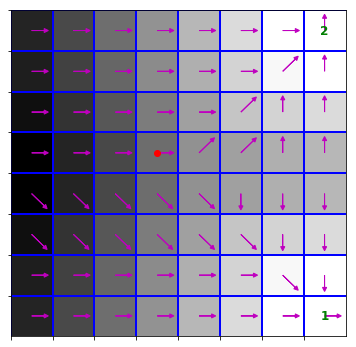

0.5
acting


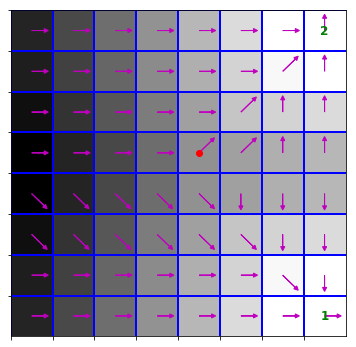

0.5
acting


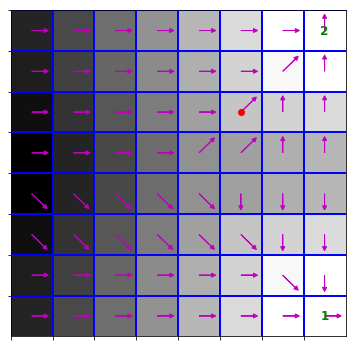

0.5
acting


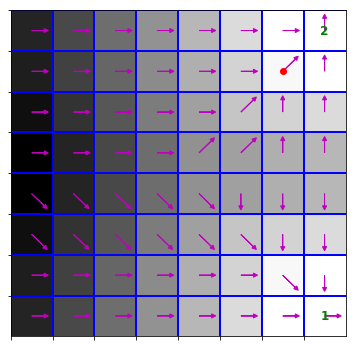

0.5
acting


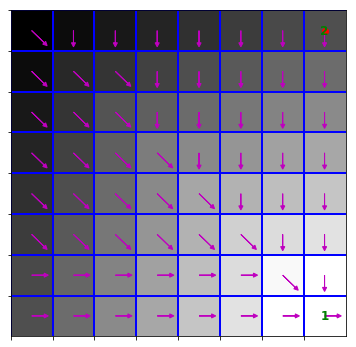

0.5
acting


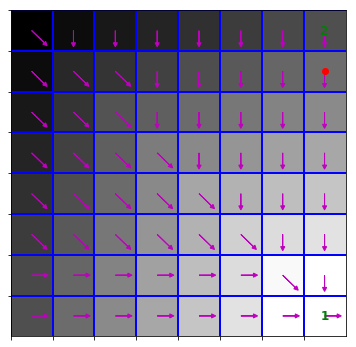

0.5
acting


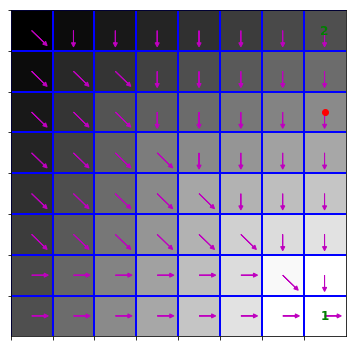

0.5
acting


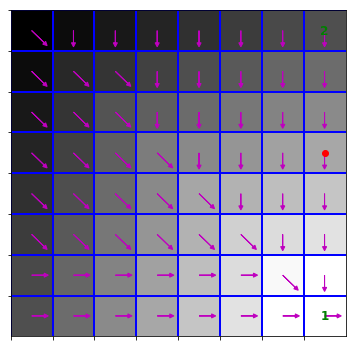

0.5
acting


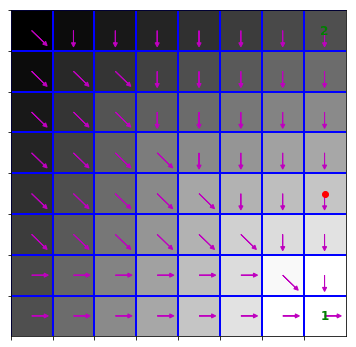

0.5
acting


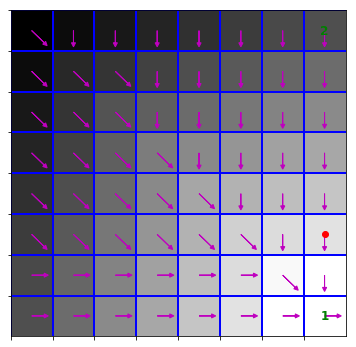

0.5
acting


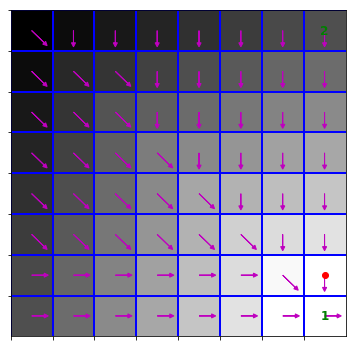

0.5
acting


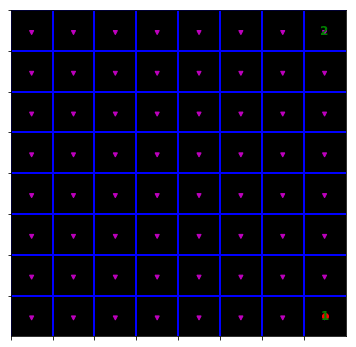

0.5


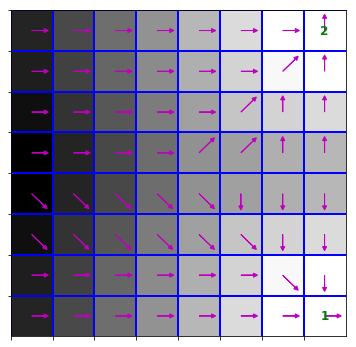

In [25]:
mdp1 = MDP(FrozenLakeEnvSequentialMultigoal(goal=1, is_slippery=False))
mdp2 = MDP(FrozenLakeEnvSequentialMultigoal(goal=2, is_slippery=False))
initial_belief = Belief(24<<2, mdp1.nS, 0.5)
support_vectors_2 = pbvi(mdp1, mdp2, initial_belief, 200, num_iter=25)

mdp1 = MDP(FrozenLakeEnvSequentialMultigoal(goal=1, is_slippery=False))
mdp2 = MDP(FrozenLakeEnvSequentialMultigoal(goal=2, is_slippery=False))
true_mdp = MDP(FrozenLakeEnvSequentialMultigoal(goal=1, is_slippery=False))

!rm -r figures/exp6
traj = run_mixing_agent(true_mdp, mdp1, mdp2, support_vectors_2, w1=0.5, img_folder='exp6')

In [ ]:
if True:
    pickle.dump(support_vectors, open('support_vectors.pkl', 'wb'))

if True:
    support_vectors = pickle.load(open('support_vectors.pkl', 'rb'))